##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Chapter 8 - Conditional Manatees

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/statistical_rethinking/notebooks/08_conditional_manatees"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/08_conditional_manatees.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/08_conditional_manatees.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/examples/statistical_rethinking/notebooks/08_conditional_manatees.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Imports and utility functions


In [2]:
#@title Install { display-mode: "form" }
TF_Installation = 'System' #@param ['TF Nightly', 'TF Stable', 'System']

if TF_Installation == 'TF Nightly':
  !pip install -q --upgrade tf-nightly
  print('Installation of `tf-nightly` complete.')
elif TF_Installation == 'TF Stable':
  !pip install -q --upgrade tensorflow
  print('Installation of `tensorflow` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

In [3]:
#@title Install { display-mode: "form" }
TFP_Installation = "System" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

In [4]:
#@title Install { display-mode: "form" }

# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    print("Installing arviz ...")
    !pip install -q arviz

In [5]:
# Core
import collections
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [6]:
az.style.use('seaborn-colorblind')

## Sampling helpers


In [7]:
USE_XLA = False              #@param
USE_MCMC = True             #@param

In [8]:
def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: v.numpy()
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

In [9]:
NUMBER_OF_SAMPLES = 2000           #@param

MCMC_NUMBER_OF_CHAINS  = 2        #@param 
MCMC_NUMBER_OF_BURNIN  = 500      #@param
MCMC_NUMBER_OF_LEAPFROG_STEPS = 4 #@param

VI_LEARNING_RATE = 0.1            #@param
VI_NUMBER_OF_STEPS = 2000         #@param
VI_SAMPLE_SIZE = 1                #@param


@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_hmc_chain(init_state,
                  bijectors, 
                  step_size, 
                  target_log_prob_fn, 
                  num_leapfrog_steps=MCMC_NUMBER_OF_LEAPFROG_STEPS,
                  num_samples=NUMBER_OF_SAMPLES,
                  burnin=MCMC_NUMBER_OF_BURNIN):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
    )         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors,
    )       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat    

def sample_posterior_vi(
              jdc, 
              observed_data,
              init_config,
              vi_config=dict(),
              num_samples=NUMBER_OF_SAMPLES):
    
    assert init_config is not None
    
    # expecting the order of keys is same 
    # as that of definition in the model function
    params = init_config.keys()
    
    init_state = dict()
    constraining_bijectors = dict()
    for p in params:
        init_state[p] = init_config[p]['state'][0]
        constraining_bijectors[p] = init_config[p]['bijector']
        
    initial_unconstrained_loc = tf.nest.map_structure(
                lambda b, x: b.inverse(x) if b is not None else x,
                constraining_bijectors, init_state)

    def target_log_prob_fn(*args, **kwargs):
      newargs = []
      for k in params:
        newargs.append(kwargs[k])

      newargs = newargs + list(observed_data)
      return jdc.log_prob(*newargs)
        
    surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
                event_shape=tf.nest.map_structure(tf.shape, init_state),
                constraining_bijectors=constraining_bijectors,
                initial_unconstrained_loc=initial_unconstrained_loc,
                initial_unconstrained_scale=1e-4)  
    
    learning_rate = vi_config.get('learning_rate', VI_LEARNING_RATE)
    num_steps     = vi_config.get('num_steps', VI_NUMBER_OF_STEPS)
    sample_size   = vi_config.get('sample_size', VI_SAMPLE_SIZE)
    
    losses = tfp.vi.fit_surrogate_posterior(
                  target_log_prob_fn,
                  surrogate_posterior=surrogate_posterior,
                  num_steps=num_steps,
                  optimizer=tf.optimizers.Adam(learning_rate),
                  sample_size=sample_size)

    results = surrogate_posterior.sample((MCMC_NUMBER_OF_CHAINS, num_samples))
    
    # fake sample_stats to trigger arviz
    # create a proper InferenceData structure
    sample_stats = dict(fake_entry=tf.random.normal(shape=(num_samples, MCMC_NUMBER_OF_CHAINS)))
        
    az_trace = _trace_to_arviz(trace=results, sample_stats=sample_stats)

    return results, az_trace


def sample_posterior_hmc(
              jdc, 
              observed_data,
              init_config,
              mcmc_config=dict(),
              num_samples=NUMBER_OF_SAMPLES):
    
    assert init_config is not None
    
    # expecting the order of keys is same 
    # as that of definition in the model function
    params = init_config.keys()
    
    init_state = []
    bijectors = []
    for p in params:
        init_state.append(init_config[p]['state'])
        bijectors.append(init_config[p]['bijector'])

    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)  
    
    
    step_size  = mcmc_config.get('step_size', 0.1)
    num_chains = mcmc_config.get('num_chains', MCMC_NUMBER_OF_CHAINS)
    burnin     = mcmc_config.get('burnin', MCMC_NUMBER_OF_BURNIN)
    
    results, sample_stats = run_hmc_chain(
        init_state,
        bijectors,
        step_size=step_size,
        target_log_prob_fn=target_log_prob_fn,                                      
        num_samples=num_samples, 
        burnin=burnin,
    )

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))      
    
    print(sampler_stats)
        
    transposed_results = []
    
    for r in results:        
        if len(r.shape) == 2:
            transposed_shape = [1,0]
        elif len(r.shape) == 3:
            transposed_shape = [1,0,2] 
        else:
            transposed_shape = [1,0,2,3] 
        
        transposed_results.append(tf.transpose(r, transposed_shape))

    posterior = dict(zip(params, transposed_results))        

    az_trace = _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

    return posterior, az_trace

def sample_posterior(
              jdc, 
              observed_data,
              init_config,
              mcmc_config=dict(),
              vi_config=dict(),
              num_samples=NUMBER_OF_SAMPLES):
    
    if USE_MCMC:
        return sample_posterior_hmc(jdc, observed_data, init_config,mcmc_config,num_samples)
    
    return sample_posterior_vi(jdc, observed_data, init_config,mcmc_config,num_samples)    


## Dataset URLs & Utils


In [10]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"

RUGGED_DATASET_PATH = f"{_BASE_URL}/rugged.csv"
TULIPS_DATASET_PATH = f"{_BASE_URL}/tulips.csv"

In [11]:
# A utility method to convert data (columns) from pandas dataframe
# into tensors with appropriate type
def df_to_tensors(name, df, columns, default_type=tf.float32):
    """ name : Name of the dataset
        df : pandas dataframe
        colums : a list of names that have the same type or
                 a dictionary where keys are the column names and values are the tensorflow type (e.g. tf.float32)
    """
    if isinstance(columns,dict):
        column_names = columns.keys()
        fields = [tf.cast(df[k].values, dtype=v) for k,v in columns.items()]    
    else:
        column_names = columns        
        fields = [tf.cast(df[k].values, dtype=default_type) for k in column_names]    
        
    # build the cls
    tuple_cls = collections.namedtuple(name, column_names)    
    # build the obj
    return tuple_cls._make(fields) 

# Introduction

## 8.1 Building an interaction

### 8.1.1 Making a rugged model

##### Code 8.1


Every inference is conditional on something whether we notice it or not !

So far in the book, it was assumed that the predictor variable has an independent association with the mean of the outcome. What if want to allow the association to be conditional ?

In [12]:
d = pd.read_csv(RUGGED_DATASET_PATH, sep=";")

# make log version of outcome
d["log_gdp"] = d["rgdppc_2000"].pipe(np.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

# split countries into Africa and not-Africa
d_A1 = dd[dd["cont_africa"] == 1]  # Africa
d_A0 = dd[dd["cont_africa"] == 0]  # not Africa

Note - terrain ruggedness is divided by the maximum value observed

##### Code 8.2

In [13]:
def model_8_1(rugged_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=1., name='alpha'), sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name='beta'), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = alpha + beta * (rugged_std - 0.215)
        
        log_gdp_std = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  

##### Code 8.3

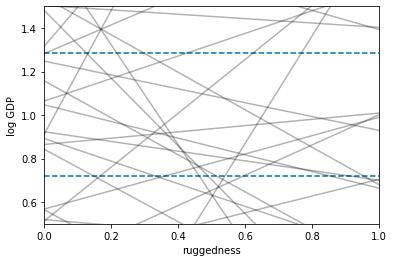

In [14]:
jdc_8_1 = model_8_1(rugged_std=dd["rugged_std"].values)

sample_alpha, sample_beta, sample_sigma, _ = jdc_8_1.sample(1000)

# set up the plot dimensions
plt.subplot(xlim=(0, 1), ylim=(0.5, 1.5),
            xlabel="ruggedness", ylabel="log GDP")
plt.gca().axhline(dd.log_gdp_std.min(), ls="--")
plt.gca().axhline(dd.log_gdp_std.max(), ls="--")

# draw 50 lines from the prior
rugged_seq = np.linspace(-0.1, 1.1, num=30)

jdc_8_1_test = model_8_1(rugged_std=rugged_seq)

ds, _ = jdc_8_1_test.sample_distributions(value=[
    sample_alpha,
    sample_beta,
    sample_sigma,
    None
])

mu = ds[-1].distribution.loc

for i in range(50):
    plt.plot(rugged_seq, mu[i], "k", alpha=0.3)

##### Code 8.4

In [15]:
np.sum(np.abs(sample_beta) > 0.6) / sample_beta.shape[0]

0.553

##### Code 8.5

In [16]:
tdf = df_to_tensors('Rugged', dd, ['rugged_std', 'log_gdp_std'])

In [17]:
def model_8_1(rugged_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=0.1, name='alpha'), sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.3, name='beta'), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + beta[...,tf.newaxis] * (rugged_std - 0.215)
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  


jdc_8_1 = model_8_1(tdf.rugged_std)

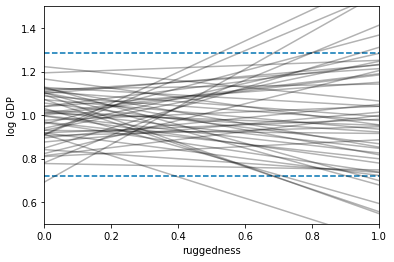

In [18]:
sample_alpha, sample_beta, sample_sigma, _ = jdc_8_1.sample(1000)

# set up the plot dimensions
plt.subplot(xlim=(0, 1), ylim=(0.5, 1.5),
            xlabel="ruggedness", ylabel="log GDP")
plt.gca().axhline(dd.log_gdp_std.min(), ls="--")
plt.gca().axhline(dd.log_gdp_std.max(), ls="--")

# draw 50 lines from the prior
rugged_seq = np.linspace(-0.1, 1.1, num=30)

jdc_8_1_test = model_8_1(rugged_std=rugged_seq)

ds, _ = jdc_8_1_test.sample_distributions(value=[
    sample_alpha,
    sample_beta,
    sample_sigma,
    None
])

mu = tf.squeeze(ds[-1].distribution.loc)

for i in range(50):
    plt.plot(rugged_seq, mu[i], "k", alpha=0.3)

##### Code 8.6

In [19]:
init_state = [
    tf.ones([MCMC_NUMBER_OF_CHAINS]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.ones([MCMC_NUMBER_OF_CHAINS]),
]

init_config = dict(
    alpha  = dict(state=init_state[0], bijector=tfb.Identity()),
    beta   = dict(state=init_state[1], bijector=tfb.Identity()),
    sigma  = dict(state=init_state[2], bijector=tfb.Exp())
)

posterior_8_1, trace_8_1 = sample_posterior(jdc_8_1,
                               init_config=init_config,
                               observed_data=(tdf.log_gdp_std,))

az.summary(trace_8_1, hdi_prob=0.89)

Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
{'mean_tree_accept': <tf.Tensor: shape=(2000, 2), dtype=float32, numpy=
array([[-6.2040710e-01,  1.3679504e-01],
       [ 7.0053101e-01, -7.3557281e-01],
       [-3.2823944e-01,  7.6021576e-01],
       ...,
       [ 3.8879395e-02, -4.2276001e+00],
       [ 2.1949005e-01, -1.1901855e-03],
       [-1.6262817e-01, -1.2275696e-01]], dtype=float32)>}


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.000,0.011,0.985,1.018,0.000,0.000,1504.0,1504.0,1508.0,1766.0,1.0
beta,0.004,0.056,-0.082,0.096,0.002,0.001,1134.0,1134.0,1134.0,1641.0,1.0
sigma,0.138,0.008,0.126,0.150,0.000,0.000,1097.0,1097.0,1086.0,1897.0,1.0


### 8.1.2 Adding an indicator variable isn't enough

##### Code 8.7

In [20]:
# make variable to index Africa (0) or not (1)
dd["cid"] = np.where(dd.cont_africa.values == 1, 0, 1)

dd["cid"]

2      0
4      1
7      1
8      1
9      1
      ..
229    1
230    1
231    0
232    0
233    0
Name: cid, Length: 170, dtype: int64

##### Code 8.8

In [21]:
tdf = df_to_tensors('Rugged', dd, {
    'rugged_std' : tf.float32,
    'log_gdp_std' : tf.float32,
    'cid' : tf.int32
})

In [22]:
def model_8_2(cid, rugged_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=0.1, name='alpha'), sample_shape=2))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.3, name='beta'), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = tf.gather(alpha, cid, axis=-1) + beta[...,tf.newaxis] * (rugged_std - 0.215)
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  


jdc_8_2 = model_8_2(tdf.cid, rugged_std=tdf.rugged_std)

In [23]:
init_state = [
    tf.ones([MCMC_NUMBER_OF_CHAINS, 2]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.ones([MCMC_NUMBER_OF_CHAINS]),
]

init_config = dict(
    alpha  = dict(state=init_state[0], bijector=tfb.Identity()),
    beta   = dict(state=init_state[1], bijector=tfb.Identity()),
    sigma  = dict(state=init_state[2], bijector=tfb.Exp())
)


posterior_8_2, trace_8_2 = sample_posterior(
                                jdc_8_2, 
                                init_config=init_config,
                                observed_data=(tdf.log_gdp_std,))

{'mean_tree_accept': <tf.Tensor: shape=(2000, 2), dtype=float32, numpy=
array([[ 0.44662476,  0.07923889],
       [-1.7903976 , -0.09365845],
       [ 0.07542419,  0.23698425],
       ...,
       [-0.3047638 , -0.55513   ],
       [-0.7093506 ,  0.31301117],
       [-0.4529953 ,  0.5459442 ]], dtype=float32)>}


In [24]:
az.summary(trace_8_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.880,0.016,0.854,0.906,0.000,0.000,3926.0,3926.0,3910.0,2248.0,1.0
alpha[1],1.050,0.010,1.034,1.066,0.000,0.000,1100.0,1098.0,1107.0,1246.0,1.0
beta,-0.046,0.046,-0.120,0.023,0.001,0.001,1740.0,1451.0,1728.0,1398.0,1.0
sigma,0.114,0.006,0.104,0.124,0.000,0.000,1268.0,1268.0,1258.0,1743.0,1.0


##### Code 8.9

In [25]:
def compute_and_store_log_likelihood_for_model_8_1():
    
    sample_alpha = posterior_8_1["alpha"]
    sample_beta  = posterior_8_1["beta"]
    sample_sigma = posterior_8_1["sigma"]
    
    ds, _ = jdc_8_1.sample_distributions(value=[
        sample_alpha, 
        sample_beta, 
        sample_sigma, 
        None
    ])
    
    log_likelihood_8_1 = ds[-1].distribution.log_prob(tdf.log_gdp_std).numpy()    
    
    # we need to insert this in the sampler_stats
    sample_stats_8_1 = trace_8_1.sample_stats
    
    coords = [sample_stats_8_1.coords['chain'], sample_stats_8_1.coords['draw'], np.arange(170)]

    sample_stats_8_1["log_likelihood"] = xr.DataArray(
        log_likelihood_8_1, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_8_1()

In [26]:
# We need to first compute the log likelihoods so as to be able to compare them
def compute_and_store_log_likelihood_for_model_8_2():
    
    sample_alpha = posterior_8_2["alpha"]
    sample_beta  = posterior_8_2["beta"]
    sample_sigma = posterior_8_2["sigma"]
    
    ds, _ = jdc_8_2.sample_distributions(value=[
        sample_alpha, 
        sample_beta, 
        sample_sigma,
        None
    ])
    
    log_likelihood_8_2 = ds[-1].distribution.log_prob(tdf.log_gdp_std).numpy() 
    
    # we need to insert this in the sampler_stats
    sample_stats_8_2 = trace_8_2.sample_stats
    
    coords = [sample_stats_8_2.coords['chain'], sample_stats_8_2.coords['draw'], np.arange(170)]

    sample_stats_8_2["log_likelihood"] = xr.DataArray(
        log_likelihood_8_2, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_8_2()

In [27]:
az.compare({"m8.1": trace_8_1,
            "m8.2": trace_8_2}, scale='deviance')

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m8.2,0,-252.462,4.05782,0,0.999997,12.673,0,False,deviance
m8.1,1,-188.895,2.56039,63.5678,3.09376e-06,14.0181,14.6691,False,deviance


##### Code 8.10

In [28]:
az.summary(trace_8_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.880,0.016,0.854,0.906,0.000,0.000,3926.0,3926.0,3910.0,2248.0,1.0
alpha[1],1.050,0.010,1.034,1.066,0.000,0.000,1100.0,1098.0,1107.0,1246.0,1.0
beta,-0.046,0.046,-0.120,0.023,0.001,0.001,1740.0,1451.0,1728.0,1398.0,1.0
sigma,0.114,0.006,0.104,0.124,0.000,0.000,1268.0,1268.0,1258.0,1743.0,1.0


##### Code 8.11

In [29]:
diff_a = trace_8_2.posterior["alpha"][:,:, 0] - trace_8_2.posterior["alpha"][:,:, 1]

In [30]:
trace_8_2.posterior["diff_a"] = diff_a

az.summary(trace_8_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.880,0.016,0.854,0.906,0.000,0.000,3926.0,3926.0,3910.0,2248.0,1.0
alpha[1],1.050,0.010,1.034,1.066,0.000,0.000,1100.0,1098.0,1107.0,1246.0,1.0
beta,-0.046,0.046,-0.120,0.023,0.001,0.001,1740.0,1451.0,1728.0,1398.0,1.0
sigma,0.114,0.006,0.104,0.124,0.000,0.000,1268.0,1268.0,1258.0,1743.0,1.0
diff_a,-0.169,0.019,-0.200,-0.139,0.000,0.000,2294.0,2279.0,2284.0,2236.0,1.0


##### Code 8.12

In [31]:
rugged_seq = np.linspace(start=-1, stop=1.1, num=30)

sample_alpha = posterior_8_2["alpha"][0]
sample_beta  = posterior_8_2["beta"][0]
sample_sigma = posterior_8_2["sigma"][0]

# compute mu over samples, fixing cid=1
jdc_8_2_test_cid_1 = model_8_2(np.repeat(1,30), rugged_std=rugged_seq)

ds, samples = jdc_8_2_test_cid_1.sample_distributions(value=[
    sample_alpha,
    sample_beta, 
    sample_sigma,
    None
])

mu_NotAfrica = tf.squeeze(ds[-1].distribution.loc)
mu_NotAfrica_mu = tf.reduce_mean(mu_NotAfrica, 0)
mu_NotAfrica_ci = tfp.stats.percentile(mu_NotAfrica, q=(1.5, 98.5), axis=0)

# compute mu over samples, fixing cid=0
jdc_8_2_test_cid_0 = model_8_2(np.repeat(0,30), rugged_std=rugged_seq)

ds, samples = jdc_8_2_test_cid_0.sample_distributions(value=[
    sample_alpha, 
    sample_beta, 
    sample_sigma,
    None
])

mu_Africa = tf.squeeze(ds[-1].distribution.loc)
mu_Africa_mu = tf.reduce_mean(mu_Africa, 0)
mu_Africa_ci = tfp.stats.percentile(mu_Africa, q=(1.5, 98.5), axis=0)

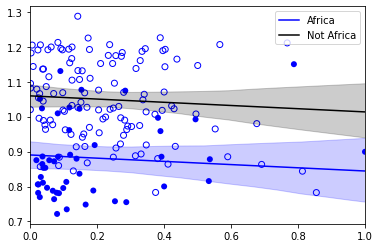

In [32]:
# draw figure 8.4 in the book [note - no code was provided for it in the book]

plt.xlim(0.0, 1.0)
plt.scatter(dd.rugged_std, dd.log_gdp_std, 
            edgecolors=["none" if i == 0 else "b" for i in dd["cid"]],
            facecolors=["none" if i == 1 else "b" for i in dd["cid"]])

# draw MAP line
plt.plot(rugged_seq, mu_Africa_mu, "b", label="Africa")
plt.fill_between(rugged_seq, mu_Africa_ci[0], mu_Africa_ci[1], color="b", alpha=0.2)

plt.plot(rugged_seq, mu_NotAfrica_mu, "k", label="Not Africa")
plt.fill_between(rugged_seq, mu_NotAfrica_ci[0], mu_NotAfrica_ci[1], color="k", alpha=0.2)

plt.legend();

##### Code 8.13

In [33]:
def model_8_3(cid, rugged_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=0.1, name='alpha'), sample_shape=2))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.3, name='beta'), sample_shape=2))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = tf.gather(alpha, cid, axis=-1) + tf.gather(beta, cid, axis=-1) * (rugged_std - 0.215)
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  


jdc_8_3 = model_8_3(tdf.cid, rugged_std=tdf.rugged_std)

In [34]:
init_state = [
    tf.ones([MCMC_NUMBER_OF_CHAINS, 2]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS, 2]),
    tf.ones([MCMC_NUMBER_OF_CHAINS]),
]

init_config = dict(
    alpha  = dict(state=init_state[0], bijector=tfb.Identity()),
    beta   = dict(state=init_state[1], bijector=tfb.Identity()),
    sigma  = dict(state=init_state[2], bijector=tfb.Exp())
)


posterior_8_3, trace_8_3 = sample_posterior(
                                jdc_8_3, 
                                init_config=init_config,
                                observed_data=(tdf.log_gdp_std,))

{'mean_tree_accept': <tf.Tensor: shape=(2000, 2), dtype=float32, numpy=
array([[ 0.75717163,  0.46572876],
       [ 0.2668152 , -0.4754181 ],
       [-0.27236938, -6.905388  ],
       ...,
       [-0.69207764,  0.11453247],
       [-4.809334  ,  0.07795715],
       [-0.15864563,  0.05259705]], dtype=float32)>}


##### Code 8.14

In [35]:
az.summary(trace_8_3, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.887,0.016,0.863,0.914,0.000,0.000,1979.0,1979.0,1993.0,1992.0,1.00
alpha[1],1.051,0.010,1.034,1.067,0.000,0.000,2370.0,2364.0,2377.0,1742.0,1.00
beta[0],0.134,0.072,0.019,0.248,0.003,0.002,593.0,593.0,596.0,987.0,1.01
beta[1],-0.145,0.054,-0.225,-0.055,0.002,0.001,1205.0,1204.0,1209.0,1633.0,1.00
sigma,0.111,0.006,0.101,0.120,0.000,0.000,1012.0,1008.0,1027.0,1498.0,1.00


##### Code 8.15

In [36]:
# We need to first compute the log likelihoods so as to be able to compare them
def compute_and_store_log_likelihood_for_model_8_3():
    
    sample_alpha = posterior_8_3["alpha"]
    sample_beta  = posterior_8_3["beta"]
    sample_sigma = posterior_8_3["sigma"]
    
    ds, _ = jdc_8_3.sample_distributions(value=[
        sample_alpha, 
        sample_beta, 
        sample_sigma,
        None
    ])
    
    log_likelihood_8_3 = ds[-1].distribution.log_prob(tdf.log_gdp_std).numpy()    
    
    # we need to insert this in the sampler_stats
    sample_stats_8_3 = trace_8_3.sample_stats
    
    coords = [sample_stats_8_3.coords['chain'], sample_stats_8_3.coords['draw'], np.arange(170)]

    sample_stats_8_3["log_likelihood"] = xr.DataArray(
        log_likelihood_8_3, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_8_3()

In [37]:
az.compare({"m8.1": trace_8_1,
            "m8.2": trace_8_2,
            "m8.3": trace_8_3}, scale='deviance')

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m8.3,0,-259.433,4.87856,0,0.839426,12.8266,0,False,deviance
m8.2,1,-252.462,4.05779,6.9707,0.160574,14.7435,6.59323,False,deviance
m8.1,2,-188.895,2.56039,70.5385,3.78738e-07,14.8209,14.9713,False,deviance


##### Code 8.16

In [38]:
az.waic(trace_8_3, pointwise=True)

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tfp-interim/env/lib/python3.7/site-packages/arviz/stats/stats.py:1415: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 by 170 log-likelihood matrix

          Estimate       SE
elpd_waic   129.76     7.32
p_waic        4.83        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

### 8.1.4 Plotting the interaction

##### Code 8.17

In [39]:
rugged_seq = np.linspace(start=-1, stop=1.1, num=30)

sample_alpha = posterior_8_3["alpha"][0]
sample_beta  = posterior_8_3["beta"][0]
sample_sigma = posterior_8_3["sigma"][0]

# compute mu over samples, fixing cid=1
jdc_8_3_test_cid_1 = model_8_3(np.repeat(1,30), rugged_std=rugged_seq)

ds, samples = jdc_8_3_test_cid_1.sample_distributions(value=[
    sample_alpha, 
    sample_beta, 
    sample_sigma,
    None
])

mu_NotAfrica = tf.squeeze(ds[-1].distribution.loc)
mu_NotAfrica_mu = tf.reduce_mean(mu_NotAfrica, 0)
mu_NotAfrica_ci = tfp.stats.percentile(mu_NotAfrica, q=(1.5, 98.5), axis=0)

# compute mu over samples, fixing cid=0
jdc_8_3_test_cid_0 = model_8_3(np.repeat(0,30), rugged_std=rugged_seq)

ds, samples = jdc_8_3_test_cid_0.sample_distributions(value=[
                sample_alpha, 
                sample_beta, 
                sample_sigma, 
                None
])

mu_Africa = tf.squeeze(ds[-1].distribution.loc)
mu_Africa_mu = tf.reduce_mean(mu_Africa, 0)
mu_Africa_ci = tfp.stats.percentile(mu_Africa, q=(1.5, 98.5), axis=0)


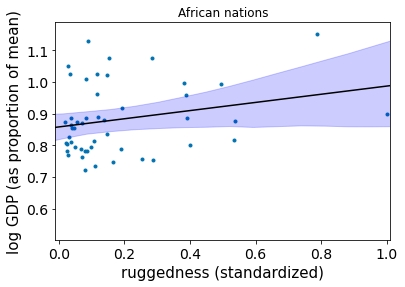

In [40]:
az.plot_pair(d_A1[["rugged_std", "log_gdp_std"]].to_dict(orient="list"))
plt.gca().set(xlim=(-0.01, 1.01), xlabel="ruggedness (standardized)",
              ylabel="log GDP (as proportion of mean)")

plt.plot(rugged_seq, mu_Africa_mu, "k")
plt.fill_between(rugged_seq, mu_Africa_ci[0], mu_Africa_ci[1], color="b", alpha=0.2)
plt.title("African nations")
plt.show()

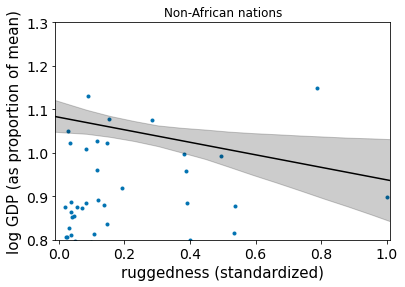

In [41]:
az.plot_pair(d_A1[["rugged_std", "log_gdp_std"]].to_dict(orient="list"))
plt.gca().set(xlim=(-0.01, 1.01), xlabel="ruggedness (standardized)",
              ylim=(0.8,1.3),
              ylabel="log GDP (as proportion of mean)")

plt.plot(rugged_seq, mu_NotAfrica_mu, "k")
plt.fill_between(rugged_seq, mu_NotAfrica_ci[0], mu_NotAfrica_ci[1], color="k", alpha=0.2)
plt.title("Non-African nations")
plt.show()

## 8.2 Symmetry of interactions

##### Code 8.18

In [42]:
# TODO - draw corresponding graph (Figure 8.6)

rugged_seq = np.linspace(start=-0.2, stop=1.2, num=30)
delta = mu_Africa_mu - mu_NotAfrica_mu

## 8.3 Continuous interactions

### 8.3.1 A winter flower

##### Code 8.19

In [43]:
d = pd.read_csv(TULIPS_DATASET_PATH, sep=";")
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bed     27 non-null     object 
 1   water   27 non-null     int64  
 2   shade   27 non-null     int64  
 3   blooms  27 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 992.0+ bytes


,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


##### Code 8.20

In [44]:
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()

##### Code 8.21

In [45]:
a = tfd.Normal(loc=0.5, scale=1.).sample((int(1e4),))
np.sum((a < 0) | (a > 1)) / a.shape[0]

0.6232

##### Code 8.22

In [46]:
a = tfd.Normal(loc=0.5, scale=0.25).sample((int(1e4),))
np.sum((a < 0) | (a > 1)) / a.shape[0]

0.0465

##### Code 8.23

In [47]:
tdf = df_to_tensors("Tulip", d, ['blooms_std', 'water_cent', 'shade_cent'])

In [48]:
def model_8_4(water_cent, shade_cent,):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=0.25, name='alpha'), sample_shape=1))
        betaW = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaW'), sample_shape=1))
        betaS = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaS'), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + betaW[...,tf.newaxis] * water_cent + betaS[...,tf.newaxis] * shade_cent
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  


jdc_8_4 = model_8_4(shade_cent=tdf.shade_cent, 
                    water_cent=tdf.water_cent)

In [49]:
init_state = [
    0.5 * tf.ones([MCMC_NUMBER_OF_CHAINS]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.ones([MCMC_NUMBER_OF_CHAINS]),
]

init_config = dict(
    alpha  = dict(state=init_state[0], bijector=tfb.Identity()),
    betaW  = dict(state=init_state[1], bijector=tfb.Identity()),
    betaS  = dict(state=init_state[2], bijector=tfb.Identity()),
    sigma  = dict(state=init_state[3], bijector=tfb.Exp())
)


posterior_8_4, trace_8_4 = sample_posterior(
                                jdc_8_4, 
                                init_config=init_config,
                                observed_data=(tdf.blooms_std,))

{'mean_tree_accept': <tf.Tensor: shape=(2000, 2), dtype=float32, numpy=
array([[ 0.09107447, -0.41976643],
       [ 1.7180004 ,  0.08913326],
       [ 0.12445259, -0.5944586 ],
       ...,
       [ 0.39775753,  0.1802206 ],
       [-0.46867466, -0.56153584],
       [ 1.0802355 , -0.9739461 ]], dtype=float32)>}


##### Code 8.24

In [50]:
def model_8_5(water_cent, shade_cent):
    def _generator():
        alpha  = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=0.25, name='alpha'), sample_shape=1))
        betaW  = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaW'), sample_shape=1))
        betaS  = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaS'), sample_shape=1))
        betaWS = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaWS'), sample_shape=1))
        sigma  = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + \
                betaW[...,tf.newaxis]  * water_cent + \
                betaS[...,tf.newaxis]  * shade_cent + \
                betaWS[...,tf.newaxis] * shade_cent * water_cent
        
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  

jdc_8_5 = model_8_5(shade_cent=tdf.shade_cent, 
                    water_cent=tdf.water_cent)

In [51]:
init_state = [
    0.5 * tf.ones([MCMC_NUMBER_OF_CHAINS]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.ones([MCMC_NUMBER_OF_CHAINS]),
]

init_config = dict(
    alpha  = dict(state=init_state[0], bijector=tfb.Identity()),
    betaW  = dict(state=init_state[1], bijector=tfb.Identity()),
    betaS  = dict(state=init_state[2], bijector=tfb.Identity()),
    betaWS = dict(state=init_state[3], bijector=tfb.Identity()),
    sigma  = dict(state=init_state[4], bijector=tfb.Exp())
)


posterior_8_5, trace_8_5 = sample_posterior(
                                jdc_8_5, 
                                init_config=init_config,
                                observed_data=(tdf.blooms_std,))

{'mean_tree_accept': <tf.Tensor: shape=(2000, 2), dtype=float32, numpy=
array([[-1.5947819 , -1.3553715 ],
       [-5.431081  , -0.51894855],
       [-0.6542454 , -2.6375809 ],
       ...,
       [ 0.21466541,  0.6640129 ],
       [-0.27668953, -0.61704445],
       [-1.4316998 ,  0.16806412]], dtype=float32)>}


### 8.3.3 Plotting posterior predictions

##### Code 8.25

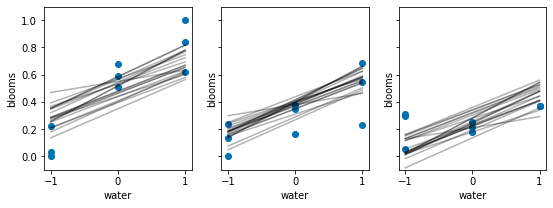

In [52]:
sample_alpha  = posterior_8_4['alpha'][0]
sample_betaW  = posterior_8_4['betaW'][0]
sample_betaS  = posterior_8_4['betaS'][0]    
sample_sigma  = posterior_8_4['sigma'][0]

_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)  # 3 plots in 1 row
for ax, s in zip(axes, range(-1, 2)):
    idx = d.shade_cent == s
    ax.scatter(d.water_cent[idx], d.blooms_std[idx])
    ax.set(xlim=(-1.1, 1.1), ylim=(-0.1, 1.1), xlabel="water", ylabel="blooms")

    shade_cent=s
    water_cent=np.arange(-1, 2)    
    
    jdc_8_4_test = model_8_4(water_cent=tf.cast(water_cent, dtype=tf.float32),
                             shade_cent=tf.cast(shade_cent, dtype=tf.float32))
    
    ds, _ = jdc_8_4_test.sample_distributions(value=[
        sample_alpha, 
        sample_betaW, 
        sample_betaS, 
        sample_sigma, 
        None
    ])
    
    mu = tf.squeeze(ds[-1].distribution.loc)    

    for i in range(20):
        ax.plot(range(-1, 2), mu[i], "k", alpha=0.3)

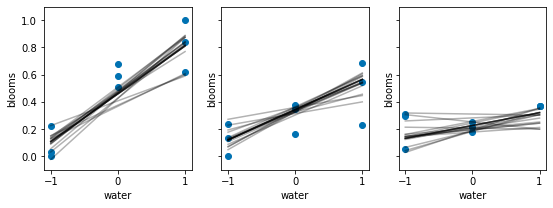

In [53]:
# Code for plotting model 8.5 is not listed in the book but there are corresponding figures so
# draw them here

sample_alpha  = posterior_8_5['alpha'][0]
sample_betaW  = posterior_8_5['betaW'][0]
sample_betaS  = posterior_8_5['betaS'][0]    
sample_betaWS = posterior_8_5['betaWS'][0]
sample_sigma  = posterior_8_5['sigma'][0]
    
_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)  # 3 plots in 1 row
for ax, s in zip(axes, range(-1, 2)):
    idx = d.shade_cent == s
    ax.scatter(d.water_cent[idx], d.blooms_std[idx])
    ax.set(xlim=(-1.1, 1.1), ylim=(-0.1, 1.1), xlabel="water", ylabel="blooms")

    shade_cent=s
    water_cent=np.arange(-1, 2)
    
    jdc_8_5_test = model_8_5(water_cent=tf.cast(water_cent, dtype=tf.float32),
                             shade_cent=tf.cast(shade_cent, dtype=tf.float32))
    
    ds, _ = jdc_8_5_test.sample_distributions(value=[
        sample_alpha,  
        sample_betaW,  
        sample_betaS,  
        sample_betaWS, 
        sample_sigma,  
        None
    ])
    
    mu = tf.squeeze(ds[-1].distribution.loc) 

    for i in range(20):
        ax.plot(range(-1, 2), mu[i], "k", alpha=0.3)

### 8.3.4 Plotting prior predictions

##### Code 8.26

In [54]:
# prior for 8.5
prior_8_5 = jdc_8_5.sample(1000)